In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### Summary Statistics and Plots

In [83]:
# load data and drop rows where climate data is missing (January 2014 and December 2019)
green_cabs = pd.read_csv("Green_Cab_data/merged_grouped_PU.csv").dropna()
yellow_cabs = pd.read_csv("Yellow_Cab_data/merged_grouped_PU.csv").dropna()
fhv_cabs = pd.read_csv("For_Hire_Vehicle_data/merged_grouped_PU.csv")
# drop row PULocationID
green_cabs = green_cabs.drop(columns=["PULocationID"])
yellow_cabs = yellow_cabs.drop(columns=["PULocationID"])
fhv_cabs = fhv_cabs.drop(columns=["PUlocationID"])
# rename falsely labelled distance column
green_cabs = green_cabs.rename(columns={"fare_amount_mean": "trip_distance_mean"})
yellow_cabs = yellow_cabs.rename(columns={"fare_amount_mean": "trip_distance_mean"})


##### Yearly Trips

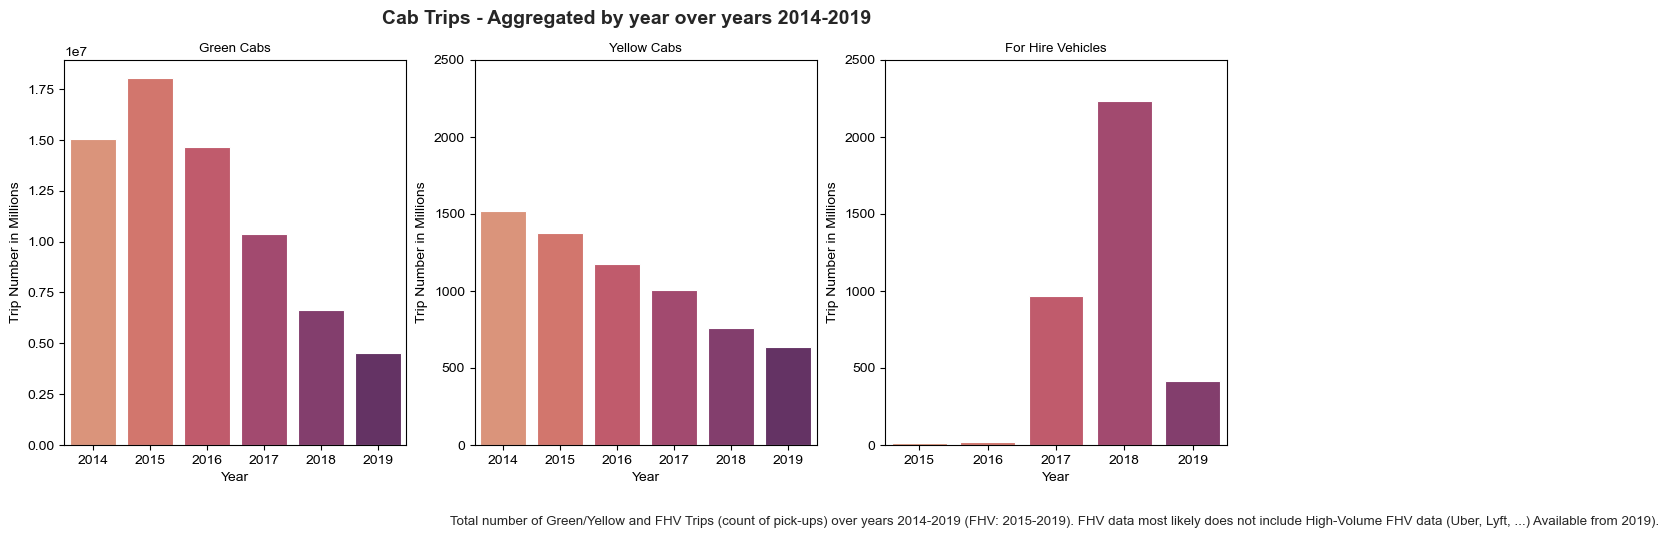

In [4]:
agg_funcs = { 'trip_number': 'sum', 'tmax_obs': 'first', 'Weekday_index': 'first', 'pr_obs': 'first', 'season': 'first', 'windspeed_obs': 'first', 'holiday': 'first', 'Snowdepth': 'first'}
# create a month variable to group by month
green_cabs["year"] = pd.DatetimeIndex(green_cabs["date_pickup"]).year
yellow_cabs["year"] = pd.DatetimeIndex(yellow_cabs["date_pickup"]).year
fhv_cabs["year"] = pd.DatetimeIndex(fhv_cabs["date_pickup"]).year
yearly_data_green = green_cabs.groupby(["year"]).agg(agg_funcs).reset_index()
yearly_data_yellow = yellow_cabs.groupby(["year"]).agg(agg_funcs).reset_index()
yearly_data_fhv = fhv_cabs.groupby(["year"]).agg(agg_funcs).reset_index()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.set_style("darkgrid")
sns.set_context("paper")
colors = sns.color_palette("flare")
sns.barplot(x="year", y="trip_number", data=yearly_data_green, ax=axs[0],palette = colors)
sns.barplot(x="year", y="trip_number", data=yearly_data_yellow, ax=axs[1], palette = colors)
sns.barplot(x="year", y="trip_number", data=yearly_data_fhv, ax=axs[2], palette = colors)
axs[0].set_title("Green Cabs")
axs[1].set_title("Yellow Cabs")
axs[2].set_title("For Hire Vehicles")
axs[0].set_xlabel("Year")
axs[1].set_xlabel("Year")
axs[2].set_xlabel("Year")
axs[0].set_ylabel("Trip Number in Millions")
axs[1].set_ylabel("Trip Number in Millions")
axs[2].set_ylabel("Trip Number in Millions")
axs[1].set_yticks(plt.yticks()[0], [str(int(tick/1e05)) for tick in plt.yticks()[0]])
axs[2].set_yticks(plt.yticks()[0], [str(int(tick/1e05)) for tick in plt.yticks()[0]])

fig.suptitle("Cab Trips - Aggregated by year over years 2014-2019", fontsize=14, fontweight="bold")
plt.text(0.5, -0.2, "Total number of Green/Yellow and FHV Trips (count of pick-ups) over years 2014-2019 (FHV: 2015-2019). FHV data most likely does not include High-Volume FHV data (Uber, Lyft, ...) Available from 2019). ", ha="center", va="center", transform=plt.gca().transAxes)
plt.savefig("Figures/Yearly_Cab_Trips.png")
plt.show()

##### Daily Trips - Ridership by temperature bins

In [11]:
# aggregate data on a daily level without pickup locations
agg_funcs = { 'trip_number': 'sum', 'tmax_obs': 'first', 'Weekday_index': 'first', 'pr_obs': 'first', 'season': 'first', 'windspeed_obs': 'first', 'holiday': 'first', 'Snowdepth': 'first'}
bins = list(range(-18, 42, 3))
labels = [str(bins[i]) + "-" + str(bins[i+1]) for i in range(len(bins)-1)]
daily_data_green = green_cabs.groupby('date_pickup', as_index=False).agg(agg_funcs)
daily_data_yellow = yellow_cabs.groupby('date_pickup', as_index=False).agg(agg_funcs)
daily_data_fhv = fhv_cabs.groupby('date_pickup', as_index=False).agg(agg_funcs)
# add a variable temperature bin to the data (strings): less than 0 if tmax_obs is smaller than 0, ...
daily_data_green["temperature_bin"] = pd.cut(daily_data_green["tmax_obs"], bins=bins, labels=labels)
daily_data_yellow["temperature_bin"] = pd.cut(daily_data_yellow["tmax_obs"], bins=bins, labels=labels)
daily_data_fhv["temperature_bin"] = pd.cut(daily_data_fhv["tmax_obs"], bins=bins, labels=labels)
# count the number of appereances for each bin and store as a dictionary with the bin as key
green_temp_bins = daily_data_green["temperature_bin"].value_counts().to_dict()
yellow_temp_bins = daily_data_yellow["temperature_bin"].value_counts().to_dict()
fhv_temp_bins = daily_data_fhv["temperature_bin"].value_counts().to_dict()
daily_data_green_temp = daily_data_green.groupby('temperature_bin', as_index=False).agg(agg_funcs)
daily_data_yellow_temp = daily_data_yellow.groupby('temperature_bin', as_index=False).agg(agg_funcs)
daily_data_fhv_temp = daily_data_fhv.groupby('temperature_bin', as_index=False).agg(agg_funcs)
# add a column with the occurence of the temperature bin in the data with the dictionary
daily_data_green_temp["no_days with temperature"] = daily_data_green_temp["temperature_bin"].map(green_temp_bins).astype(int)
daily_data_green_temp["trip_per_day"] = daily_data_green_temp["trip_number"]/daily_data_green_temp["no_days with temperature"]
daily_data_yellow_temp["no_days with temperature"] = daily_data_yellow_temp["temperature_bin"].map(yellow_temp_bins).astype(int)
daily_data_yellow_temp["trip_per_day"] = daily_data_yellow_temp["trip_number"]/daily_data_yellow_temp["no_days with temperature"]
daily_data_fhv_temp["no_days with temperature"] = daily_data_fhv_temp["temperature_bin"].map(fhv_temp_bins).astype(int)
daily_data_fhv_temp["trip_per_day"] = daily_data_fhv_temp["trip_number"]/daily_data_fhv_temp["no_days with temperature"]

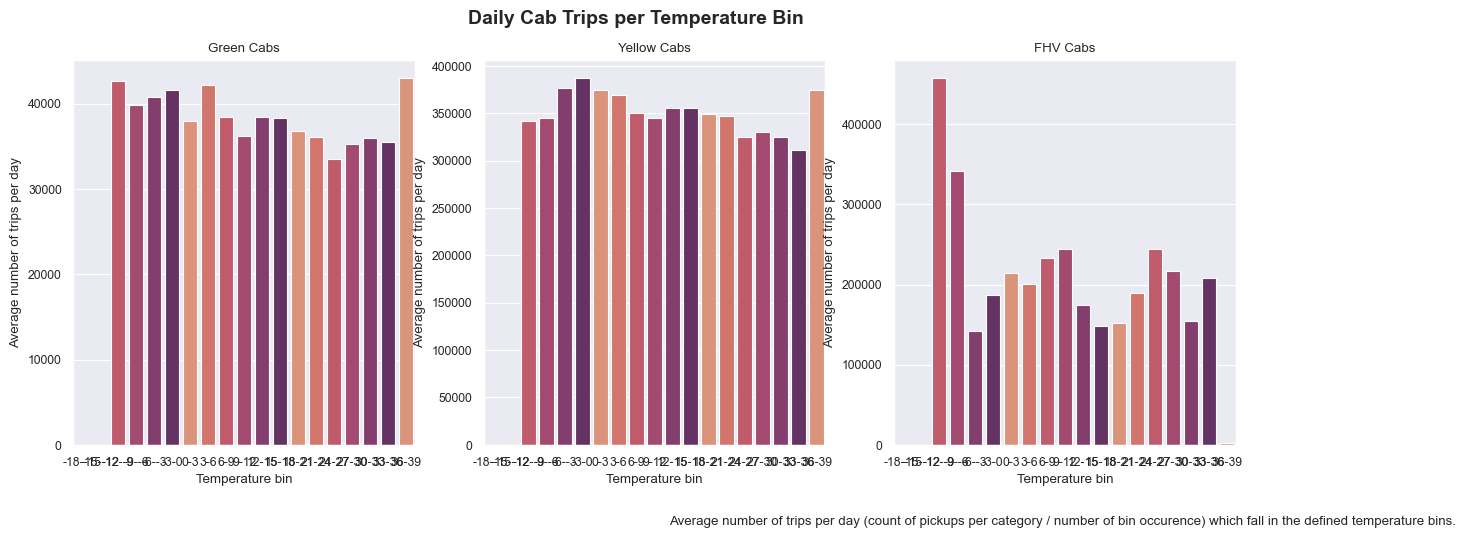

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.set_style("darkgrid")
sns.set_context("paper")
colors = sns.color_palette("flare")
sns.barplot(x="temperature_bin", y="trip_per_day", data=daily_data_green_temp, ax=axs[0],palette = colors)
sns.barplot(x="temperature_bin", y="trip_per_day", data=daily_data_yellow_temp, ax=axs[1], palette = colors)
sns.barplot(x="temperature_bin", y="trip_per_day", data=daily_data_fhv_temp, ax=axs[2], palette = colors)
axs[0].set_title("Green Cabs")
axs[1].set_title("Yellow Cabs")
axs[2].set_title("FHV Cabs")
axs[0].set_xlabel("Temperature bin")
axs[1].set_xlabel("Temperature bin")
axs[2].set_xlabel("Temperature bin")
axs[0].set_ylabel("Average number of trips per day")
axs[1].set_ylabel("Average number of trips per day")
axs[2].set_ylabel("Average number of trips per day")

fig.suptitle("Daily Cab Trips per Temperature Bin", fontsize=14, fontweight="bold")
plt.text(0.5, -0.2, "Average number of trips per day (count of pickups per category / number of bin occurence) which fall in the defined temperature bins. ", ha="center", va="center", transform=plt.gca().transAxes)
plt.savefig("Figures/Trips_by_Temperature.png")
plt.show()


##### Mean distance by temperature bin - only Green and Yellow Cabs

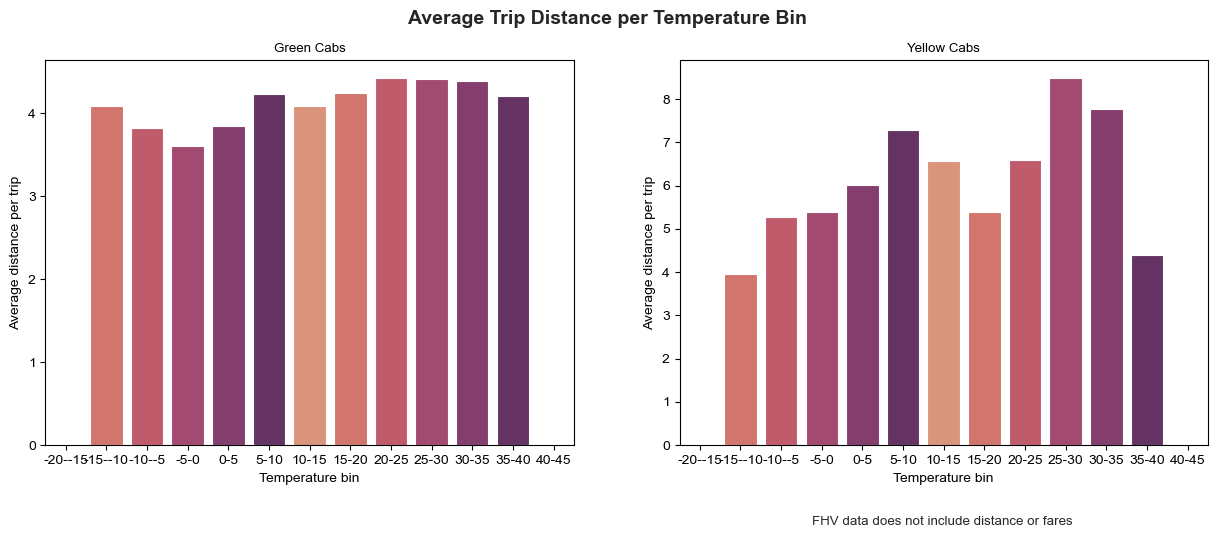

In [7]:
# aggregate data on a daily level without pickup locations
agg_funcs_2 = {"trip_distance_mean": "mean" , "total_amount_mean" : "mean", 'trip_number': 'sum', 'tmax_obs': 'first', 'Weekday_index': 'first', 'pr_obs': 'first', 'season': 'first', 'windspeed_obs': 'first', 'holiday': 'first', 'Snowdepth': 'first'}
bins = list(range(-20, 50, 5))
labels = [str(bins[i]) + "-" + str(bins[i+1]) for i in range(len(bins)-1)]
daily_data_green_2 = green_cabs.groupby('date_pickup', as_index=False).agg(agg_funcs_2)
daily_data_yellow_2 = yellow_cabs.groupby('date_pickup', as_index=False).agg(agg_funcs_2)
# add a variable temperature bin to the data (strings): less than 0 if tmax_obs is smaller than 0, ...
daily_data_green_2["temperature_bin"] = pd.cut(daily_data_green_2["tmax_obs"], bins=bins, labels=labels)
daily_data_yellow_2["temperature_bin"] = pd.cut(daily_data_yellow_2["tmax_obs"], bins=bins, labels=labels)
daily_data_green_temp_2 = daily_data_green_2.groupby('temperature_bin', as_index=False).agg(agg_funcs_2)
daily_data_yellow_temp_2 = daily_data_yellow_2.groupby('temperature_bin', as_index=False).agg(agg_funcs_2)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("darkgrid")
sns.set_context("paper")
colors = sns.color_palette("flare")
sns.barplot(x="temperature_bin", y="trip_distance_mean", data=daily_data_green_temp_2, ax=axs[0],palette = colors)
sns.barplot(x="temperature_bin", y="trip_distance_mean", data=daily_data_yellow_temp_2, ax=axs[1], palette = colors)
axs[0].set_title("Green Cabs")
axs[1].set_title("Yellow Cabs")
axs[0].set_xlabel("Temperature bin")
axs[1].set_xlabel("Temperature bin")
axs[0].set_ylabel("Average distance per trip")
axs[1].set_ylabel("Average distance per trip")


fig.suptitle("Average Trip Distance per Temperature Bin", fontsize=14, fontweight="bold")
plt.text(0.5, -0.2, "FHV data does not include distance or fares ", ha="center", va="center", transform=plt.gca().transAxes)
plt.savefig("Figures/Distance_by_Temperature.png")
plt.show()



##### Total Trips per month

In [ ]:
green_cabs["month"] = pd.DatetimeIndex(green_cabs["date_pickup"]).month
yellow_cabs["month"] = pd.DatetimeIndex(yellow_cabs["date_pickup"]).month
fhv_cabs["month"] = pd.DatetimeIndex(fhv_cabs["date_pickup"]).month

agg_funcs = { 'trip_number': 'sum', 'tmax_obs': 'mean', 'Weekday_index': 'first', 'pr_obs': 'first', 'season': 'first', 'windspeed_obs': 'first', 'holiday': 'first', 'Snowdepth': 'first'}
monthly_data_green = green_cabs.groupby('month', as_index=False).agg(agg_funcs)
monthly_data_yellow = yellow_cabs.groupby('month', as_index=False).agg(agg_funcs)
monthly_data_fhv = fhv_cabs.groupby('month', as_index=False).agg(agg_funcs)

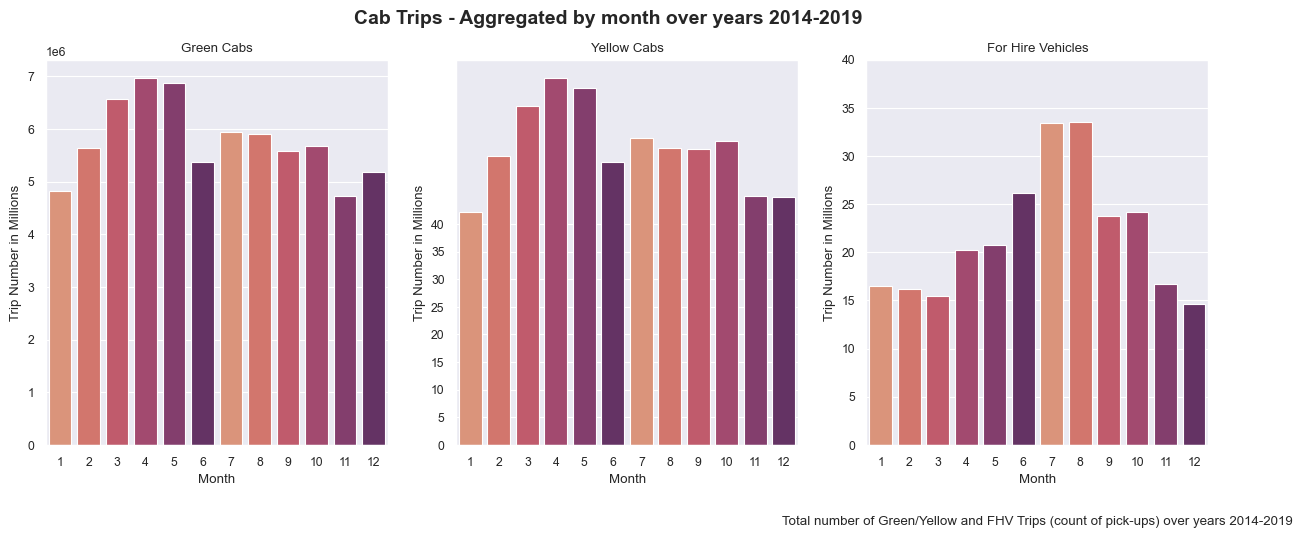

In [148]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.set_style("darkgrid")
sns.set_context("paper")
colors = sns.color_palette("flare")
sns.barplot(x="month", y="trip_number", data=monthly_data_green, ax=axs[0],palette = colors)
sns.barplot(x="month", y="trip_number", data=monthly_data_yellow, ax=axs[1], palette = colors)
sns.barplot(x="month", y="trip_number", data=monthly_data_fhv, ax=axs[2], palette = colors)
axs[0].set_title("Green Cabs")
axs[1].set_title("Yellow Cabs")
axs[2].set_title("For Hire Vehicles")
axs[0].set_xlabel("Month")
axs[1].set_xlabel("Month")
axs[2].set_xlabel("Month")
axs[0].set_ylabel("Trip Number in Millions")
axs[1].set_ylabel("Trip Number in Millions")
axs[2].set_ylabel("Trip Number in Millions")
axs[1].set_yticks(plt.yticks()[0], [str(int(tick/1e06)) for tick in plt.yticks()[0]])
axs[2].set_yticks(plt.yticks()[0], [str(int(tick/1e06)) for tick in plt.yticks()[0]])

fig.suptitle("Cab Trips - Aggregated by month over years 2014-2019", fontsize=14, fontweight="bold")
plt.text(0.5, -0.2, "Total number of Green/Yellow and FHV Trips (count of pick-ups) over years 2014-2019", ha="center", va="center", transform=plt.gca().transAxes)
plt.savefig("Figures/Monthly_Cab_Trips.png")
plt.show()

#####  Time Series

In [84]:
# aggregate data on a daily level without pickup locations
agg_funcs = { 'trip_number': 'sum', 'tmax_obs': 'first', 'Weekday_index': 'first', 'pr_obs': 'first', 'season': 'first', 'windspeed_obs': 'first', 'Snowdepth': 'first' }
daily_data_green = green_cabs.groupby('date_pickup', as_index=False).agg(agg_funcs)
daily_data_yellow = yellow_cabs.groupby('date_pickup', as_index=False).agg(agg_funcs)
daily_data_fhv = fhv_cabs.groupby('date_pickup', as_index=False).agg(agg_funcs)

daily_data_green["date_pickup"] = pd.to_datetime(daily_data_green["date_pickup"])
daily_data_yellow["date_pickup"] = pd.to_datetime(daily_data_yellow["date_pickup"])
daily_data_fhv["date_pickup"] = pd.to_datetime(daily_data_fhv["date_pickup"])
daily_data_green.set_index('date_pickup', inplace=True)
daily_data_yellow.set_index('date_pickup', inplace=True)
daily_data_fhv.set_index('date_pickup', inplace=True)



In [86]:
fhv = pd.read_csv("For_Hire_Vehicle_data/data_regression_PU_with_HV.csv")
agg_funcs = { 'trip_number': 'sum', 'tmax_obs': 'first', 'Weekday_index': 'first', 'pr_obs': 'first', 'season': 'first', 'windspeed_obs': 'first', 'holiday': 'first', 'Snowdepth': 'first'}

fhv["date_pickup"] = pd.to_datetime(fhv["date_pickup"])
daily_data_fhv = fhv.groupby('date_pickup', as_index=False).agg(agg_funcs)
daily_data_fhv.set_index('date_pickup', inplace=True)

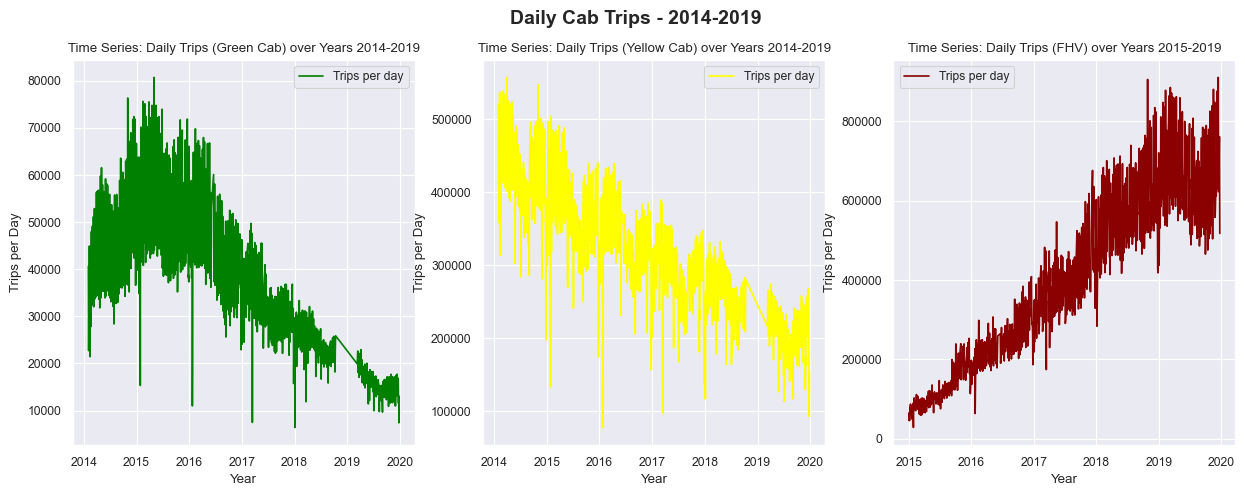

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(daily_data_green.index, daily_data_green['trip_number'], color = "green",label='Trips per day')
axs[1].plot(daily_data_yellow.index, daily_data_yellow['trip_number'], color = "yellow",label='Trips per day')
axs[2].plot(daily_data_fhv.index, daily_data_fhv['trip_number'], color = "darkred",label='Trips per day')
axs[0].set_title('Time Series: Daily Trips (Green Cab) over Years 2014-2019')
axs[1].set_title('Time Series: Daily Trips (Yellow Cab) over Years 2014-2019')
axs[2].set_title('Time Series: Daily Trips (FHV) over Years 2015-2019')
axs[0].set_xlabel("Year")
axs[1].set_xlabel("Year")
axs[2].set_xlabel("Year")
axs[0].set_ylabel("Trips per Day")
axs[1].set_ylabel("Trips per Day")
axs[2].set_ylabel("Trips per Day")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle("Daily Cab Trips - 2014-2019", fontsize=14, fontweight="bold")
plt.savefig("Figures/Time_Series_Cab_Trips.png")
plt.show()

### Chicago Summaries

In [98]:
chicago = pd.read_csv("Chigaco_data/chicago_dropoff_regression.csv")

In [25]:
chicago["year"] = pd.DatetimeIndex(chicago["date_pickup"]).year
chicago["month"] = pd.DatetimeIndex(chicago["date_pickup"]).month

In [26]:
chicago

,PULocationID,date_pickup,trip_number,avg_trip_seconds,avg_trip_miles,avg_fare,avg_tips,DATE,AWND,PRCP,...,log_total,cheby_0,cheby_1,cheby_2,cheby_3,cheby_4,cheby_5,temp_bins,year,month
0,22,2015-01-01,20,675.300000,2.255000,9.580000,0.181500,2015-01-01,15.21,0.0,...,3.044522,1,1,1,1,1,1,"(-2.0, 1.0]",2015,1
1,56,2015-01-01,1,1800.000000,0.700000,26.450000,0.000000,2015-01-01,15.21,0.0,...,0.693147,1,1,1,1,1,1,"(-2.0, 1.0]",2015,1
2,33,2015-01-01,19,664.789474,1.747368,8.650000,0.268947,2015-01-01,15.21,0.0,...,2.995732,1,1,1,1,1,1,"(-2.0, 1.0]",2015,1
3,7,2015-01-01,65,633.753846,1.941538,8.733077,0.611692,2015-01-01,15.21,0.0,...,4.189655,1,1,1,1,1,1,"(-2.0, 1.0]",2015,1
4,8,2015-01-01,412,508.868932,1.284660,7.535364,0.636578,2015-01-01,15.21,0.0,...,6.023448,1,1,1,1,1,1,"(-2.0, 1.0]",2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551500,32,2019-12-31,40,522.300000,0.921750,8.556250,0.425500,2019-12-31,16.78,0.0,...,3.713572,1,365,266449,194507405,141990139201,103652607109325,"(-2.0, 1.0]",2019,12
1551501,76,2019-12-31,1,2040.000000,18.300000,47.250000,5.550000,2019-12-31,16.78,0.0,...,0.693147,1,365,266449,194507405,141990139201,103652607109325,"(-2.0, 1.0]",2019,12
1551502,33,2019-12-31,5,667.000000,2.678000,9.800000,0.000000,2019-12-31,16.78,0.0,...,1.791759,1,365,266449,194507405,141990139201,103652607109325,"(-2.0, 1.0]",2019,12
1551503,56,2019-12-31,2,3065.500000,15.405000,44.375000,8.925000,2019-12-31,16.78,0.0,...,1.098612,1,365,266449,194507405,141990139201,103652607109325,"(-2.0, 1.0]",2019,12


In [28]:
agg_funcs = { 'trip_number': 'sum', 'avg_trip_miles': 'mean', 'avg_fare': 'mean'}
yearly_chicago = chicago.groupby(["year"]).agg(agg_funcs).reset_index()
monthly_chicago = chicago.groupby(["month"]).agg(agg_funcs).reset_index()

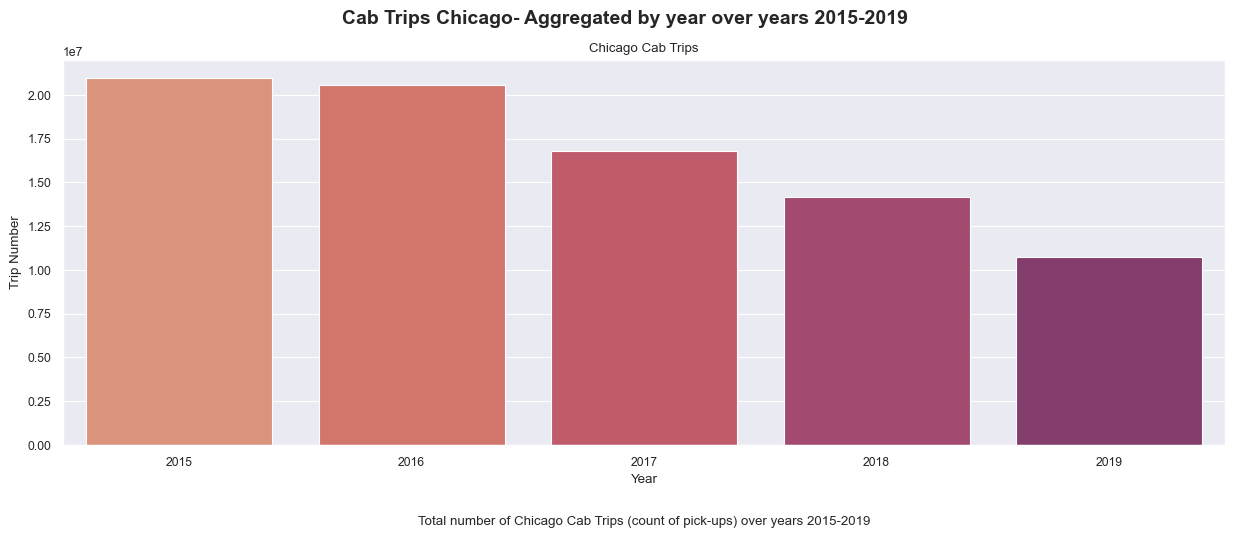

In [30]:
# create a barplot with sns- only one plot
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sns.set_style("darkgrid")
sns.set_context("paper")
colors = sns.color_palette("flare")
sns.barplot(x="year", y="trip_number", data=yearly_chicago, ax=axs,palette = colors)
axs.set_title("Chicago Cab Trips")
axs.set_xlabel("Year")
axs.set_ylabel("Trip Number")
# axs.set_yticks(plt.yticks()[0], [str(int(tick/1e05)) for tick in plt.yticks()[0]])
fig.suptitle("Cab Trips Chicago- Aggregated by year over years 2015-2019", fontsize=14, fontweight="bold")
plt.text(0.5, -0.2, "Total number of Chicago Cab Trips (count of pick-ups) over years 2015-2019", ha="center", va="center", transform=plt.gca().transAxes)
plt.savefig("Figures/Yearly_Cab_Trips_Chicago.png")
plt.show()


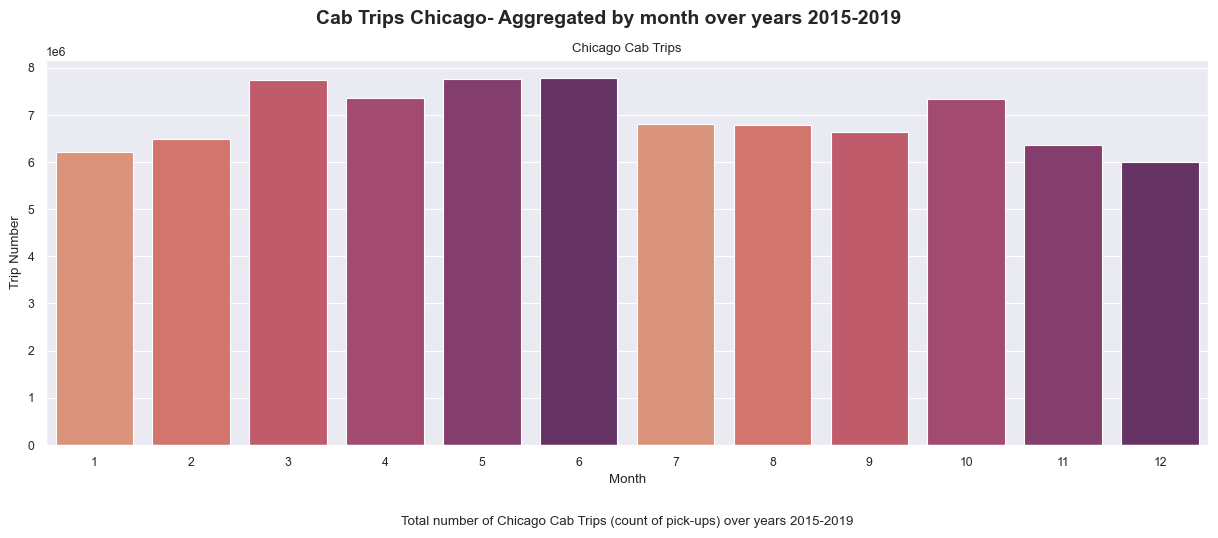

In [31]:
# same for month
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sns.set_style("darkgrid")
sns.set_context("paper")
colors = sns.color_palette("flare")
sns.barplot(x="month", y="trip_number", data=monthly_chicago, ax=axs,palette = colors)
axs.set_title("Chicago Cab Trips")
axs.set_xlabel("Month")
axs.set_ylabel("Trip Number")
# axs.set_yticks(plt.yticks()[0], [str(int(tick/1e05)) for tick in plt.yticks()[0]])
fig.suptitle("Cab Trips Chicago- Aggregated by month over years 2015-2019", fontsize=14, fontweight="bold")
plt.text(0.5, -0.2, "Total number of Chicago Cab Trips (count of pick-ups) over years 2015-2019", ha="center", va="center", transform=plt.gca().transAxes)
plt.savefig("Figures/Monthly_Cab_Trips_Chicago.png")
plt.show()

In [39]:
chicago_bins = chicago["temp_bins"].value_counts().to_dict()
# order the temperature bin column - in ascending order - so that the plot is in the right order



chicago_temp = chicago.groupby('temp_bins', as_index=False).agg(agg_funcs)
chicago_temp['x'] = chicago_temp['temp_bins'].str.extract('\((.*),').astype(float)

# Sort the DataFrame by 'x'
chicago_temp = chicago_temp.sort_values('x')
# add a column with the occurence of the temperature bin in the data with the dictionary
chicago_temp["no_days with temperature"] = chicago_temp["temp_bins"].map(chicago_bins).astype(int)
chicago_temp["trip_per_day"] = chicago_temp["trip_number"]/chicago_temp["no_days with temperature"]

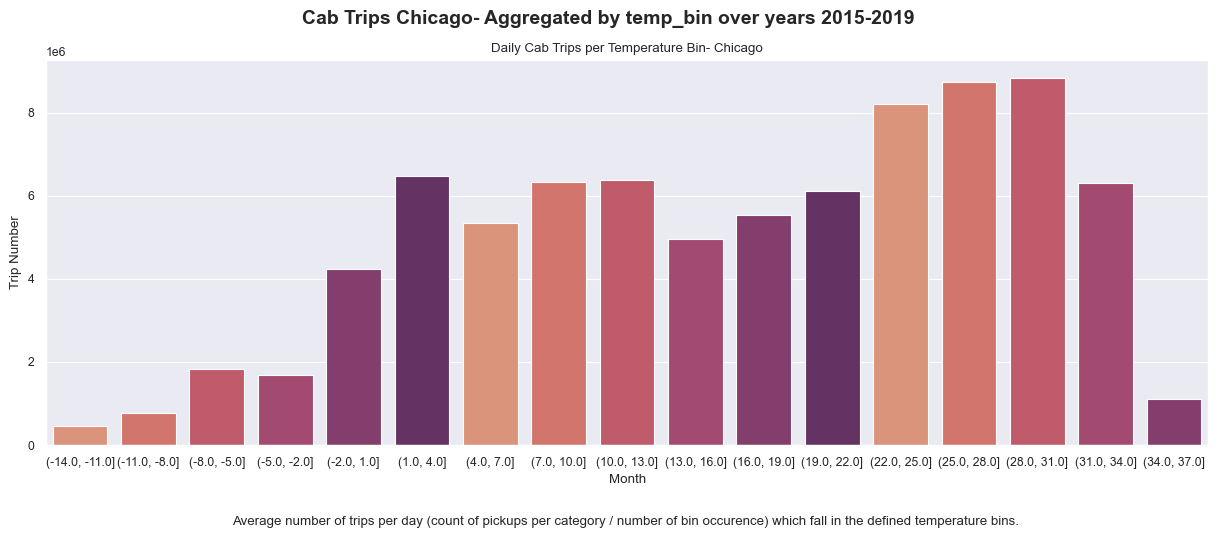

In [45]:
# same for month
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sns.set_style("darkgrid")
sns.set_context("paper")
colors = sns.color_palette("flare")
sns.barplot(x="temp_bins", y="trip_number", data=chicago_temp, ax=axs,palette = colors)
axs.set_title("Daily Cab Trips per Temperature Bin- Chicago")
axs.set_xlabel("Month")
axs.set_ylabel("Trip Number")
# axs.set_yticks(plt.yticks()[0], [str(int(tick/1e05)) for tick in plt.yticks()[0]])
fig.suptitle("Cab Trips Chicago- Aggregated by temp_bin over years 2015-2019", fontsize=14, fontweight="bold")
plt.text(0.5, -0.2, "Average number of trips per day (count of pickups per category / number of bin occurence) which fall in the defined temperature bins. ", ha="center", va="center", transform=plt.gca().transAxes)
plt.savefig("Figures/Temperature_Cab_Trips_Chicago.png")
plt.show()

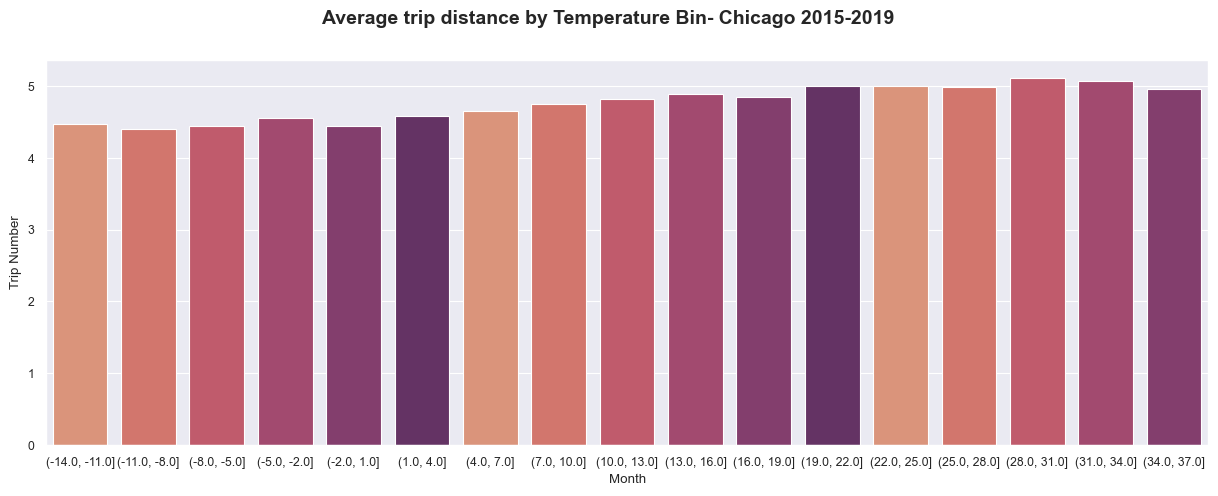

In [46]:
# same for month
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sns.set_style("darkgrid")
sns.set_context("paper")
colors = sns.color_palette("flare")
sns.barplot(x="temp_bins", y="avg_trip_miles", data=chicago_temp, ax=axs,palette = colors)

axs.set_xlabel("Month")
axs.set_ylabel("Trip Number")
# axs.set_yticks(plt.yticks()[0], [str(int(tick/1e05)) for tick in plt.yticks()[0]])
fig.suptitle("Average trip distance by Temperature Bin- Chicago 2015-2019", fontsize=14, fontweight="bold")
plt.savefig("Figures/Distance_by_temperature_Chicago.png")
plt.show()

In [91]:
chicago

,PULocationID,trip_number,avg_trip_seconds,avg_trip_miles,avg_fare,avg_tips,DATE,AWND,PRCP,tmax_obs,...,log_total,cheby_0,cheby_1,cheby_2,cheby_3,cheby_4,cheby_5,temp_bins,year,month
date_pickup,,,,,,,,,,,,,,,,,,,,,
2015-01-01,22,20,675.300000,2.255000,9.580000,0.181500,2015-01-01,15.21,0.0,0.000000,...,3.044522,1,1,1,1,1,1,"(-2.0, 1.0]",2015,1
2015-01-01,56,1,1800.000000,0.700000,26.450000,0.000000,2015-01-01,15.21,0.0,0.000000,...,0.693147,1,1,1,1,1,1,"(-2.0, 1.0]",2015,1
2015-01-01,33,19,664.789474,1.747368,8.650000,0.268947,2015-01-01,15.21,0.0,0.000000,...,2.995732,1,1,1,1,1,1,"(-2.0, 1.0]",2015,1
2015-01-01,7,65,633.753846,1.941538,8.733077,0.611692,2015-01-01,15.21,0.0,0.000000,...,4.189655,1,1,1,1,1,1,"(-2.0, 1.0]",2015,1
2015-01-01,8,412,508.868932,1.284660,7.535364,0.636578,2015-01-01,15.21,0.0,0.000000,...,6.023448,1,1,1,1,1,1,"(-2.0, 1.0]",2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,32,40,522.300000,0.921750,8.556250,0.425500,2019-12-31,16.78,0.0,-1.111111,...,3.713572,1,365,266449,194507405,141990139201,103652607109325,"(-2.0, 1.0]",2019,12
2019-12-31,76,1,2040.000000,18.300000,47.250000,5.550000,2019-12-31,16.78,0.0,-1.111111,...,0.693147,1,365,266449,194507405,141990139201,103652607109325,"(-2.0, 1.0]",2019,12
2019-12-31,33,5,667.000000,2.678000,9.800000,0.000000,2019-12-31,16.78,0.0,-1.111111,...,1.791759,1,365,266449,194507405,141990139201,103652607109325,"(-2.0, 1.0]",2019,12


In [96]:
chicago[chicago.index == "2015-01-01"].sum()

PULocationID                                                    29998
trip_number                                                     59192
avg_trip_seconds                                        790377.433045
avg_trip_miles                                            4127.167954
avg_fare                                                 15379.097058
avg_tips                                                  1046.535578
DATE                2015-01-012015-01-012015-01-012015-01-012015-0...
AWND                                                         17750.07
PRCP                                                              0.0
tmax_obs                                                          0.0
Weekday_index                                                    3501
holiday                                                          1167
Year_fact                                                        1167
Month_fact                                                       1167
log_total           

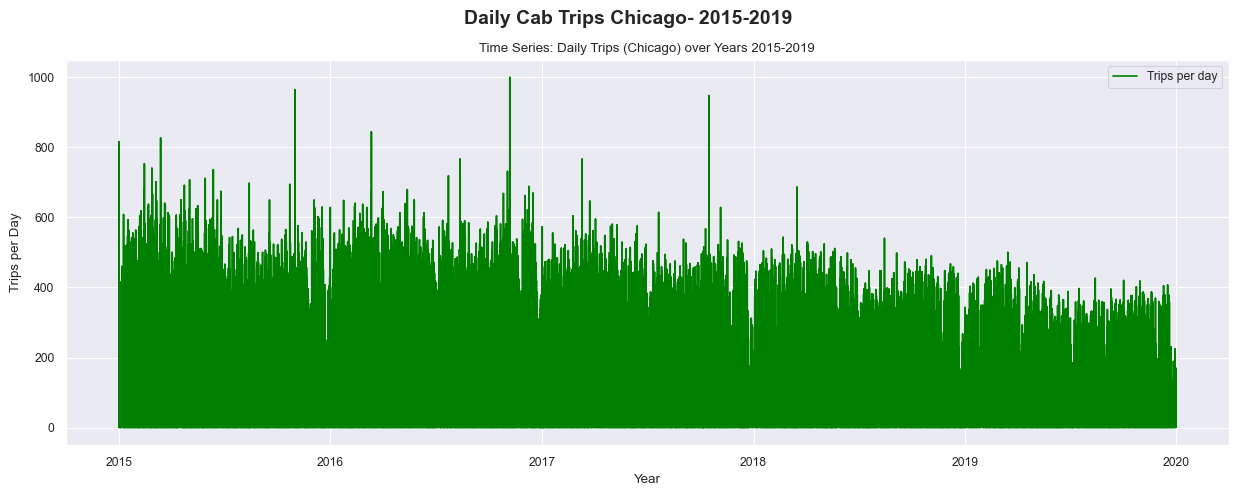

In [99]:
chicago["date_pickup"] = pd.to_datetime(chicago["date_pickup"])
chicago.set_index('date_pickup', inplace=True)

fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.plot(chicago.index, chicago['trip_number'], color = "green",label='Trips per day')
axs.set_title('Time Series: Daily Trips (Chicago) over Years 2015-2019')
axs.set_xlabel("Year")
axs.set_ylabel("Trips per Day")
axs.legend()
fig.suptitle("Daily Cab Trips Chicago- 2015-2019", fontsize=14, fontweight="bold")
plt.savefig("Figures/Time_Series_Cab_Trips_Chicago.png")
plt.show()